# Multimimensional Dyck languages

A $k$-dimensional Dyck language, $D_k$, consists of words over a $k$-letter alphabet (with the usual lexicographic ordering) satisfying the following two conditions:

* FREQ: each word contains the $k$ letters with equal frequency
* PREFIX: for every prefix of a word, the number of $a_1 \geq$ the number of $a_2\geq \ldots \geq$ the number of $a_k$

The familiar language of balanced brackets is $D_2$.

For the place of $D_k$ in the extended Chomsky hierarchy, the conjecture is that $D_k$ languages are recognizable by $(k-1)$-MCFG. For example: $D_2$ is recognized by a 1-MCFG, in other words, a simple CFG.

Your challenge is to give a 2-MCFG for $D_3$, and to show it is correct and complete. 

For background, see Moortgat (2014) A note on multidimensional Dyck languages. http://link.springer.com/chapter/10.1007/978-3-642-54789-8_16

Let us start with some helper definitions to generate the Dyck words. In Moortgat (2014) it is shown that the words of $D_k$ can be obtained by repeated shuffling of a deck of $k$ cards (the alphabet symbols). shuffle() is the standard definition for merging two lists in such a way that the order of the elements in the individual lists is respected. dshuffle() is a restricted version that avoids duplicates in case the two decks to be shuffled contain identical cards.

In [19]:
def shuffle(l,r):
    if not (l and r): # left and/or right pack are empty
        return [ l+r ]
    else:
        return [ l[0]+w for w in shuffle(l[1:],r) ] + [ r[0]+w for w in shuffle(l,r[1:]) ] 

def dshuffle(l,r):
    return [ l+r ] if not (l and r) else\
        [ (l,r)[i][0]+w for i in range(2) if not i or r[0]<l[0] for w in dshuffle(l[(i+1)%2:],r[i%2:]) ]

The function dyck(k,n) generates a list with the $k$-dimensional Dyck words with letter frequency $n$. (When you try this out, keep $n$ small: with increasing $n$ the number of words grows very quickly! You'll have to rewrite the code to use generators if you want to work with large $n$.)

In [20]:
def dyck(k,n):
    sigma = ''.join([ chr(97+i) for i in range(k) ])# a,b,c,... (k letters)
    return [ sigma*n ] if n<2 else sum([ dshuffle(sigma,w) for w in dyck(k,n-1) ],[])

In [24]:
len(dyck(3,3))

42

In [25]:
dshuffle('abc','abc')

['abcabc', 'abacbc', 'ababcc', 'aabcbc', 'aabbcc']

## Testing

If you think you have found a 2-MCFG for $D_3$, you can test it with Peter Ljunglöf's MCFG parser.

* Peter Ljunglöf (2012). Practical Parsing of Parallel Multiple Context-Free Grammars. (http://alpage.inria.fr/~clerger/tmpTAG11/cdrom/pdf/TAG+1117.pdf)

* Code available from https://github.com/heatherleaf/MCFParser.py

In [26]:
import sys
import itertools
import re
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator

%matplotlib inline

from MCFParser import *


A grammar for the MCFParser is a list of rules. A rule is a 4-tuple:

* a rule identifier (cf the ACG rule constant)
* the left-hand side (lhs) non-terminal
* a list (possibly empty) of rhs non-terminals
* a recipe how to build the string tuple of the lhs non-terminal out of the string tuples of the rhs non-terminals

The recipe is a list of lists. Its length is the dimension of the lhs nonterminal. Variables are pairs (n,m), where n refers to the n-th rhs nonterminal and m to the m-th tuple component of n (counting starts at zero).

The example grammar $\{a^n b^n c^n d^n \mid n >0\}$ in MCFParser format is given below. 

In [27]:
grammar0 = [('r0','S', ['A'], [[(0,0),(0,1)]]),
           ('r1','A',['A'],[['a',(0,0),'b'],['c',(0,1),'d']]),
           ('r2','A',[],[['a','b'],['c','d']])
           ]

p = Parser(grammar0,['S'])

There are two useful methods for testing. chart_parse() returns True/False dependiing on whether a word has a parse. parse() returns a list of abstract syntax trees for a word that is succesfully parsed.

In [28]:
for i, ast in enumerate(p.parse(list("aaabbbcccddd"))):
    print "{0}. {1}".format(i, ast)

0. ('r0', ('r1', ('r1', ('r2',))))


In [29]:
p.chart_parse(list('aabbbcccddd')) # oops - missing d ..

False

## Your turn

In [37]:
p = '''
permutations to be handled:

    badly-ordered pairs:
    //if ordered properly, they produce a well-formed type W
        A-A+
        B-B+ DOES B-, B+ even exist?
        C+C-
        B+A+ 
        C+B+
        C+A+ == A+C+ !!! SUPER IMPORTANT
    repeating pairs:
    //these act as a finite memory
        A+A+
        A-A-
        B+B+
        B-B-
        C+C+
        C-C-
    collapses of badly-ordered pairs (where K, L variables):
    //mental-note: two badly ordered pairs can be combined, if their middle singletons can be combined to produce a 
    well-formed type W
        KA+, A-L -> KL
        !ERROR KB+, B-L -> KL
        KC-, LC+ -> KL
    collapses of badly-ordered pair plus singleton:
    //mental-note: not intuitive, needs brute forcing
        A+C-, B+ -> C-C-
        B+A+, C+ -> A-A+
        C-A+, C+ -> A+  // subcase of above category: C-A+ == A+C-, C+ == C+, ε => A+C-, C+ => A+
'''
# OPPOSITE SIGN
#(AB_, [A, B_], [[x,y,z,w], e]),
#(AC_, [A, C_], [[x,y,z,w], e]),
#(BA_, [B, A_], [[x,y,z,w], e]),
#(BC_, [B, C_], [[x,y,z,w], e]),
#(CA_, [C, A_], [[x,y,z,w], e]),
#(CB_, [C, B_], [[x,y,z,w], e]),
#(A, [AB_, B], [[x, y], [z, w]]),
#(A, [AB_, C], [[x,y], [z,w]]),
#(B, [BA_, C],)

In [50]:
S, W, e = 'S', 'W', []
a, b, c = 'a', 'b', 'c'
A, A_, B, B_, C, C_ = 'A', 'A-', 'B', 'B-', 'C', 'C-'
AB, AC, BA, CA, BC, CB, AA, BB, CC = 'AB', 'AC', 'BA', 'CA', 'BC', 'CB', 'AA', 'BB', 'CC'
A_B_, A_C_, B_A_, C_A_, B_C_, C_B_, A_A_, B_B_, C_C_ = 'A-B-', 'A-C-', 'B-A-', 'C-A-', 'B-C-', 'C-B-', 'A-A-', 'B-B-', 'C-C-'
AC_, C_A, A_A, AA_ = 'AC-', 'C-A', 'A-A', 'AA-'

all_singles = [A, A_, B, B_, C, C_]

x, y, z, w = (0,0),(0,1), (1,0),(1,1)
grammar = [('r{}'.format(i), lhs, rhs, recipe) for i, (lhs, rhs, recipe) in enumerate([
# TOP
(S, [W], [[x,y]]),
# W BASE
(W, e, [[a, b, c], e]),
(W, e, [[a, b], [c]]),
(W, e, [[a], [b, c]]),
# W PERMUTATIONS
(W, [W, W], [[x, y], [z, w]]),
(W, [W, W], [[x, z], [y, w]]),
(W, [W, W], [[x, z], [w, y]]),
(W, [W, W], [[z, x], [y, w]]),
(W, [W, W], [[z, x], [w, y]]),
(W, [W, W], [[z, w], [x, y]]),
(W, [W, W], [[x, y, z], [w]]),
(W, [W, W], [[x], [y, z, w]]),
# W TRIPLE INSERTION (BASE)
(W, [W], [[a, x, b], [y, c]]),
# W TRIPLE INSERTION (COMBINATIONS)
(W, [W, W], [[a,x,b], [z,c,y,w]]),
(W, [W, W], [[a,x,b], [z,c,w,y,]]),
(W, [W, W], [[x,z,a,y,b], [w,c]]),
(W, [W, W], [[x,z,a,w,b], [y,c]]),
] +
# A+, B+, C+
sum([[
(l.upper(), e, [[l], e]),
(l.upper(), e, [e, [l]]),
(l.upper(), [W], [[l, x], [y]]),
(l.upper(), [W], [[x, l], [y]]),
(l.upper(), [W], [[x],    [y, l]]),
] for l in "abc"
], []) + [
# A-, B-, C-
('C-', [A, B], [[x, y], [z, w]]),
('A-', [B, C], [[x, y], [z, w]]),
('B-', [A, C], [[x, y], [z, w]]),
] + sum([[
# COMBINATIONS
(W, [l, r], [[x, y, z, w], e]),
(W, [l, r], [[x, y, z],    [w]]),
(W, [l, r], [[x, y],       [z, w]]),
# (W, [l, r], [[x],          [y, z, w]]),
] for l, r in [(C_, C), (A, A_)]
], []) + [] + 
# INVERSE DOUBLES
[(k + l, [l + k], [[x], [y]]) for k in all_singles for l in all_singles] + 
# DOUBLES (BASE)
[(k + l, [k, l], [[x, y], [z, w]]) for k in all_singles for l in all_singles] +
# DOUBLES (REDUCTION)
[
(C_C_, [AC_, B], [[x, y], [z, w]]),
(C_A, [C_C_, C_A], [[x, y], [z, w]]),
(A_A, [BA, C], [[x, y], [z, w]]),
(C_A, [C_A, A_A], [[x, y], [z, w]]),
(A,   [C_A, C], [[x, y], [z, w]]),
]
# END
)]

p = Parser(grammar, [S])

## Testing $D^3$

In [ ]:
from itertools import permutations

def test_dyck(n, p):
    d3 = dyck(3, n)
    chars = 'abc' * n
    for w in permutations(chars):
        s = "".join(w)
        if s not in d3 and p.chart_parse(w):
            print('UNSOUND!!!')
            break

test_dyck(4, p)

In [54]:
p.chart_parse(list("aabbaccbc"))

True

In [55]:
p.chart_parse(list("abaacbbcc"))

True

In [56]:
p.chart_parse(list("aabbacbaccbc"))

True

In [57]:
# print unrecognized words with letter multiplicity n

def d3test(n):
    ws = dyck(3,n)
    counter_examples = filter(lambda w: not p.chart_parse(list(w)), ws)
    for i, w in enumerate(counter_examples):
        print '{0}.\t {1}'.format(i + 1, w)
    print '-------------- [{0} out of {1}] --------------'.format(len(counter_examples), len(ws))

In [58]:
d3test(4)

1.	 abaacbbcacbc
2.	 abaacbbaccbc
3.	 aababbaccbcc
4.	 abaaacbbccbc
5.	 aabbacacbbcc
6.	 aabbaacbbccc
7.	 abaacbacbbcc
8.	 abaabaccbbcc
9.	 aaabbacbbccc
10.	 abaacabbbccc
11.	 abaaacbbbccc
-------------- [11 out of 462] --------------


In [142]:
# grammar mm0 has lots of spurious ambiguity:

for t in p.parse(list("aabbcc")):
    print t

('r0', ('r5', ('r35', ('r13',), ('r28', ('r18',), ('r23',))), ('r2',)))
('r0', ('r5', ('r35', ('r13',), ('r28', ('r18',), ('r23',))), ('r34', ('r13',), ('r28', ('r17',), ('r23',)))))
('r0', ('r5', ('r35', ('r13',), ('r28', ('r18',), ('r23',))), ('r34', ('r13',), ('r28', ('r18',), ('r23',)))))
('r0', ('r5', ('r35', ('r13',), ('r28', ('r18',), ('r23',))), ('r34', ('r13',), ('r28', ('r18',), ('r22',)))))
('r0', ('r5', ('r35', ('r13',), ('r28', ('r18',), ('r23',))), ('r34', ('r13',), ('r28', ('r17',), ('r22',)))))
('r0', ('r5', ('r35', ('r13',), ('r28', ('r18',), ('r23',))), ('r32', ('r27', ('r12',), ('r17',)), ('r23',))))
('r0', ('r5', ('r35', ('r13',), ('r28', ('r18',), ('r23',))), ('r32', ('r27', ('r13',), ('r17',)), ('r23',))))
('r0', ('r5', ('r35', ('r13',), ('r28', ('r18',), ('r23',))), ('r32', ('r27', ('r13',), ('r18',)), ('r23',))))
('r0', ('r5', ('r35', ('r13',), ('r28', ('r18',), ('r23',))), ('r32', ('r27', ('r12',), ('r18',)), ('r23',))))
('r0', ('r5', ('r35', ('r13',), ('r28', 

('r0', ('r32', ('r27', ('r13',), ('r20', ('r35', ('r12',), ('r28', ('r18',), ('r23',))))), ('r22',)))
('r0', ('r32', ('r27', ('r13',), ('r20', ('r35', ('r12',), ('r28', ('r18',), ('r22',))))), ('r22',)))
('r0', ('r32', ('r27', ('r13',), ('r20', ('r35', ('r12',), ('r28', ('r17',), ('r23',))))), ('r22',)))
('r0', ('r32', ('r27', ('r13',), ('r20', ('r35', ('r12',), ('r28', ('r17',), ('r22',))))), ('r22',)))
('r0', ('r32', ('r27', ('r13',), ('r20', ('r35', ('r13',), ('r28', ('r18',), ('r23',))))), ('r22',)))
('r0', ('r32', ('r27', ('r13',), ('r20', ('r35', ('r13',), ('r28', ('r18',), ('r22',))))), ('r22',)))
('r0', ('r32', ('r27', ('r13',), ('r20', ('r35', ('r13',), ('r28', ('r17',), ('r23',))))), ('r22',)))
('r0', ('r32', ('r27', ('r13',), ('r20', ('r35', ('r13',), ('r28', ('r17',), ('r22',))))), ('r22',)))
('r0', ('r32', ('r27', ('r12',), ('r20', ('r3',))), ('r22',)))
('r0', ('r32', ('r27', ('r12',), ('r20', ('r35', ('r12',), ('r28', ('r18',), ('r23',))))), ('r22',)))
('r0', ('r32', ('r2

In [57]:
# a queue-based machine model
# empty queue: 'Z'
# reading 'a' pushes 'N' in front of queue
# reading 'b': cancels initial 'N' and adds final 'N'
# reading 'c': cancels final 'N'

def d3_queue(w,q='Z',steps=[]): # beginwaarden voor q en steps
    if w=='' and q=='Z':
        return steps+[(w,q)]
    elif w[0]=='a':
        return d3_queue(w[1:],'N'+q,steps+[(w[0],q)])
    elif w[0]=='b' and q[0]=='N':
        return d3_queue(w[1:],q[1:]+'N',steps+[(w[0],q)])
    elif w[0]=='c' and q[-1]=='N':
        return d3_queue(w[1:],q[:-1],steps+[(w[0],q)])
    else:
        return steps+[(w,q)]
    
# acceptance: empty input, empty queue

def d3_accept(w):
    run = d3_queue(w)
    if run[-1]==('','Z'):
        return True
    else: 
        return False

# plotting

def ybar(q):
    return (-len(q[:q.index('Z')]),len(q[q.index('Z')+1:]))

def ybars(d):
    return map(lambda x:ybar(x[1]),d)

def d3_plot(d):
    ind = np.arange(len(d))
    front = tuple(map(lambda x:x[0],ybars(d)))
    back = tuple(map(lambda x:x[1],ybars(d)))
    plt.bar(ind, front, 1.001, color='.65')
    plt.bar(ind, back, 1.001, color='.65')
    plt.xticks(ind+.5, tuple([ item[0] for item in d]) )
    plt.yticks(range(-(len(d)//3),len(d)//3,1))
    plt.axis([0,len(d),-(len(d)//3),len(d)//3])
    return None

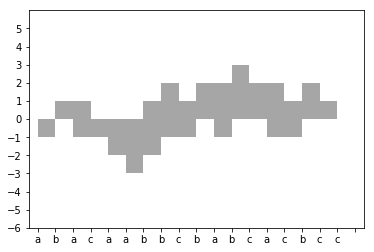

In [84]:
d3_plot(d3_queue("abacaabbcbabcacbcc"))